In [16]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DateType
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName ('Glycemic Data') \
    .getOrCreate()
spark

In [2]:
from pyspark.sql import Row
from pyspark.sql.functions import col, isnull, when, count, col, lit, row_number, expr, to_timestamp
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import matplotlib.dates as md

schema = StructType([
   StructField("HbA1c", StringType(), True),
   StructField("PID", StringType(), True),
   StructField("Gender", StringType(), True),
   StructField("Timestamp", StringType(), True),
   StructField("GlucoseValue", StringType(), True),
   StructField("Date", DateType(), True)
])

main_dataset  = spark.createDataFrame([], schema)


df1 = (spark.read
     .format("csv")
     .option("header","true")
     .load("glycemic-wearable-data/Demographics.csv"))

print("Demographics Data - ") 
df1.show(16)

row_list = df1.collect() 

index = 1
prefix = "00"

for row in df1.rdd.collect():
    id =  row.__getitem__('ID')
    prefix = "00" if int(id) <10  else "0"
    print("**************************************************")
    print("Processing Index : " +  str(index))
    print("Processing ID : " + prefix + id)
    print("Processing file :" + " glycemic-wearable-data/"+ prefix + id +"/Dexcom_" + prefix + id + ".csv")
    
    df2 = (spark.read
             .format("csv")
             .option("header","true")
             .load("glycemic-wearable-data/"+ prefix + id +"/Dexcom_" + prefix + id + ".csv"))

    dataset = df2.select(col('Timestamp (YYYY-MM-DDThh:mm:ss)').alias('Timestamp'),
                    col('Glucose Value (mg/dL)').alias('GlucoseValue'))
    print("This Dataset Count : " + str(dataset.count()))
    print("Null Value in This Dataset -")
    dataset.select([count(when(isnull(c),c)).alias(c) for c in dataset.columns]).show()

    dataset = dataset.replace('?', None)\
        .dropna(how='any')
    
    print("Null Value in This Dataset after processing -")
    dataset.select([count(when(isnull(c),c)).alias(c) for c in dataset.columns]).show()

    dataset = dataset.withColumn("HbA1c",lit(row.__getitem__('HbA1c')))
    dataset = dataset.withColumn("PID",lit(row.__getitem__('ID')))
    dataset = dataset.withColumn("Gender",lit(row.__getitem__('Gender')))
    dataset = dataset.withColumn("Date",to_timestamp("Timestamp","yyyy-MM-dd HH:mm:ss"))
    dataset = dataset.withColumn("GlucoseValue", dataset["GlucoseValue"].cast("integer"))
    dataset = dataset.select('HbA1c','PID','Gender','Timestamp','GlucoseValue','Date')
    
     
    main_dataset = main_dataset.union(dataset)
    print("Main Dataset Count : " + str(main_dataset.count()))
    print("==================================================")
    index = index+1

print("Main Dataset after Combining all the files - ") 
main_dataset.show(10)
main_dataset = main_dataset.withColumn('Diabetic', when(main_dataset.HbA1c > 5.7, 1).otherwise(0))
main_dataset = main_dataset.withColumn('Sex', when(main_dataset.Gender == "MALE", 1).otherwise(0))  

main_dataset = main_dataset.withColumn("Diabetic", main_dataset["Diabetic"].cast("integer"))
main_dataset = main_dataset.withColumn("GlucoseValue", main_dataset["GlucoseValue"].cast("integer"))
main_dataset = main_dataset.withColumn("PID", main_dataset["PID"].cast("integer"))

main_dataset= main_dataset.withColumn("EventType",expr("CASE WHEN GlucoseValue >150 THEN 'High' WHEN GlucoseValue < 80 THEN 'Low' ELSE 'Normal' END"))

print("Main Dataset after adding  Diabetic, Sex - ") 
main_dataset.show() 
main_dataset = StringIndexer(
            inputCol='EventType',
            outputCol='Event',
            handleInvalid='keep').fit(main_dataset).transform(main_dataset)

#require_featured = ['PID', 'Timestamp', 'GlucoseValue', 'Sex', 'EventType']
main_dataset.drop('Timestamp')
main_dataset.drop('EventType')

print("Main Dataset after converting EventType - ") 
main_dataset.show(10)
main_dataset.coalesce(1).write.csv('.csv', header=True)

Demographics Data - 
+---+------+-----+
| ID|Gender|HbA1c|
+---+------+-----+
| 13|  MALE|  5.7|
|  1|FEMALE|  5.5|
|  3|FEMALE|  5.9|
|  4|FEMALE|  6.4|
|  5|FEMALE|  5.7|
|  2|  MALE|  5.6|
|  6|FEMALE|  5.8|
|  7|FEMALE|  5.3|
|  8|FEMALE|  5.6|
| 10|FEMALE|  6.0|
|  9|  MALE|  6.1|
| 11|  MALE|  6.0|
| 12|  MALE|  5.6|
| 14|  MALE|  5.5|
| 15|FEMALE|  5.5|
| 16|  MALE|  5.5|
+---+------+-----+

**************************************************
Processing Index : 1
Processing ID : 013
Processing file : glycemic-wearable-data/013/Dexcom_013.csv
This Dataset Count : 1990
Null Value in This Dataset -
+---------+------------+
|Timestamp|GlucoseValue|
+---------+------------+
|       11|           7|
+---------+------------+

Null Value in This Dataset after processing -
+---------+------------+
|Timestamp|GlucoseValue|
+---------+------------+
|        0|           0|
+---------+------------+

Main Dataset Count : 1979
**************************************************
Processing Index

In [3]:
from pyspark.sql import SparkSession
data = spark.read.csv("part-00000.csv", header=True)
data.show()


+-----+---+------+-------------------+------------+--------------------+--------+---+---------+-----+
|HbA1c|PID|Gender|          Timestamp|GlucoseValue|                Date|Diabetic|Sex|EventType|Event|
+-----+---+------+-------------------+------------+--------------------+--------+---+---------+-----+
|  5.7| 13|  MALE|2020-05-28 15:21:57|          94|2020-05-28T15:21:...|       0|  1|   Normal|  0.0|
|  5.7| 13|  MALE|2020-05-28 15:26:57|          94|2020-05-28T15:26:...|       0|  1|   Normal|  0.0|
|  5.7| 13|  MALE|2020-05-28 15:31:57|          92|2020-05-28T15:31:...|       0|  1|   Normal|  0.0|
|  5.7| 13|  MALE|2020-05-28 15:36:57|          90|2020-05-28T15:36:...|       0|  1|   Normal|  0.0|
|  5.7| 13|  MALE|2020-05-28 15:41:57|          90|2020-05-28T15:41:...|       0|  1|   Normal|  0.0|
|  5.7| 13|  MALE|2020-05-28 15:46:57|          93|2020-05-28T15:46:...|       0|  1|   Normal|  0.0|
|  5.7| 13|  MALE|2020-05-28 15:51:57|          96|2020-05-28T15:51:...|       0| 

In [4]:
from pyspark.sql import functions as F
#Selecting columns
data1 = data.select("HbA1c", "GlucoseValue", "EventType")
data1.show()


+-----+------------+---------+
|HbA1c|GlucoseValue|EventType|
+-----+------------+---------+
|  5.7|          94|   Normal|
|  5.7|          94|   Normal|
|  5.7|          92|   Normal|
|  5.7|          90|   Normal|
|  5.7|          90|   Normal|
|  5.7|          93|   Normal|
|  5.7|          96|   Normal|
|  5.7|          97|   Normal|
|  5.7|          96|   Normal|
|  5.7|          95|   Normal|
|  5.7|          94|   Normal|
|  5.7|          96|   Normal|
|  5.7|          96|   Normal|
|  5.7|          97|   Normal|
|  5.7|          95|   Normal|
|  5.7|          90|   Normal|
|  5.7|          86|   Normal|
|  5.7|          89|   Normal|
|  5.7|          95|   Normal|
|  5.7|         103|   Normal|
+-----+------------+---------+
only showing top 20 rows



In [5]:
from pyspark.sql import SparkSession

#Read the CSV file
data = spark.read.csv("part-00000.csv", header=True)  # Replace "/path/to/your/data.csv" with your actual file path

#Show the schema
data.printSchema()

data.show()


root
 |-- HbA1c: string (nullable = true)
 |-- PID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- GlucoseValue: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Diabetic: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- EventType: string (nullable = true)
 |-- Event: string (nullable = true)

+-----+---+------+-------------------+------------+--------------------+--------+---+---------+-----+
|HbA1c|PID|Gender|          Timestamp|GlucoseValue|                Date|Diabetic|Sex|EventType|Event|
+-----+---+------+-------------------+------------+--------------------+--------+---+---------+-----+
|  5.7| 13|  MALE|2020-05-28 15:21:57|          94|2020-05-28T15:21:...|       0|  1|   Normal|  0.0|
|  5.7| 13|  MALE|2020-05-28 15:26:57|          94|2020-05-28T15:26:...|       0|  1|   Normal|  0.0|
|  5.7| 13|  MALE|2020-05-28 15:31:57|          92|2020-05-28T15:31:...|       0|  1|   Normal|  0.0

In [6]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

#Converting string columns to float
data1 = data1.withColumn("HbA1c", data1["HbA1c"].cast("float"))
data1 = data1.withColumn("GlucoseValue", data1["GlucoseValue"].cast("float"))

feature_columns = ['HbA1c', 'GlucoseValue']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

#Transformig the DataFrame to features column
transformed_data = assembler.transform(data1)

#Selecting only  features and label columns
selected_data = transformed_data.select('features', 'EventType')

#split the data into training and testing sets
train_data, test_data = selected_data.randomSplit([0.67, 0.33], seed=42)




In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


feature_columns = ['HbA1c', 'GlucoseValue']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

#converting string columns to float
data = data1.withColumn("HbA1c", data1["HbA1c"].cast("float"))
data = data1.withColumn("GlucoseValue", data1["GlucoseValue"].cast("float"))

#Transforming DataFrame to features column
transformed_data = assembler.transform(data)


indexer = StringIndexer(inputCol='EventType', outputCol='label')


indexer_model = indexer.fit(transformed_data)


transformed_data_indexed = indexer_model.transform(transformed_data)

#split data into training and testing
(train_data, test_data) = transformed_data_indexed.randomSplit([0.7, 0.3], seed=42)

#classification models
lr = LogisticRegression()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

#Training
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
dt_model = dt.fit(train_data)


#predictions
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)


#Evaluate the models
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

lr_accuracy = evaluator.evaluate(lr_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)


#Printing the accuracy
print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)


spark.stop()



Logistic Regression Accuracy: 1.0
Random Forest Accuracy: 0.9867893586005831
Decision Tree Accuracy: 0.9896137026239067


In [20]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics


spark = SparkSession.builder \
    .appName("Classification with Spark") \
    .getOrCreate()


data1 = spark.read.csv("part-00000.csv", header=True, inferSchema=True)

feature_columns = ['HbA1c', 'GlucoseValue']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

#Converting string columns to float
data = data1.withColumn("HbA1c", data1["HbA1c"].cast("float")) \
            .withColumn("GlucoseValue", data1["GlucoseValue"].cast("float"))

#Transforming DataFrame to features column
transformed_data = assembler.transform(data)


indexer = StringIndexer(inputCol='EventType', outputCol='label')

indexer_model = indexer.fit(transformed_data)

transformed_data_indexed = indexer_model.transform(transformed_data)

#Split data into training and testing
(train_data, test_data) = transformed_data_indexed.randomSplit([0.7, 0.3], seed=42)

#classification models
lr = LogisticRegression()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

#Train
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
dt_model = dt.fit(train_data)

#predictions
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)

#Evaluate the models
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

lr_accuracy = evaluator.evaluate(lr_predictions)
rf_accuracy = evaluator.evaluate(rf_predictions)
dt_accuracy = evaluator.evaluate(dt_predictions)

#Print the accuracy
print("Logistic Regression Accuracy:", lr_accuracy)
print("Random Forest Accuracy:", rf_accuracy)
print("Decision Tree Accuracy:", dt_accuracy)

lr_pred_and_labels = lr_predictions.select('prediction', 'label').rdd.map(tuple)
rf_pred_and_labels = rf_predictions.select('prediction', 'label').rdd.map(tuple)
dt_pred_and_labels = dt_predictions.select('prediction', 'label').rdd.map(tuple)

lr_metrics = MulticlassMetrics(lr_pred_and_labels)
rf_metrics = MulticlassMetrics(rf_pred_and_labels)
dt_metrics = MulticlassMetrics(dt_pred_and_labels)

#confusion matrix
print("Confusion Matrix for Logistic Regression:")
print(lr_metrics.confusionMatrix())

print("Confusion Matrix for Random Forest:")
print(rf_metrics.confusionMatrix())

print("Confusion Matrix for Decision Tree:")
print(dt_metrics.confusionMatrix())

spark.stop()


Logistic Regression Accuracy: 1.0
Random Forest Accuracy: 0.9846027696793003
Decision Tree Accuracy: 0.9895225947521866
Confusion Matrix for Logistic Regression:
DenseMatrix([[9869.,    0.,    0.],
             [   0.,  853.,    0.],
             [   0.,    0.,  254.]])
Confusion Matrix for Random Forest:
DenseMatrix([[9828.,    0.,   41.],
             [ 128.,  725.,    0.],
             [   0.,    0.,  254.]])
Confusion Matrix for Decision Tree:
DenseMatrix([[9.758e+03, 3.100e+01, 8.000e+01],
             [0.000e+00, 8.530e+02, 0.000e+00],
             [4.000e+00, 0.000e+00, 2.500e+02]])


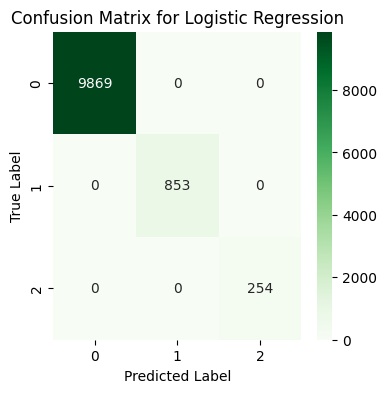

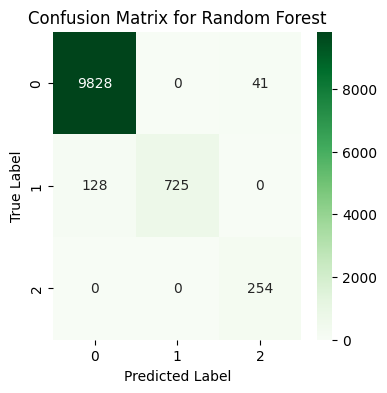

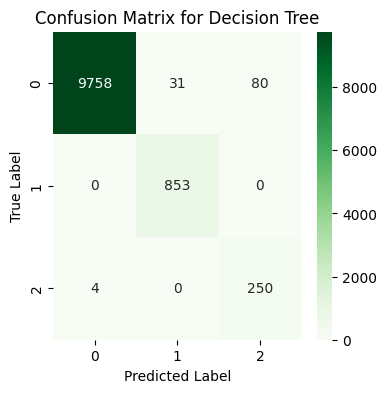

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Confusion matrix
lr_conf_matrix = lr_metrics.confusionMatrix().toArray()
rf_conf_matrix = rf_metrics.confusionMatrix().toArray()
dt_conf_matrix = dt_metrics.confusionMatrix().toArray()


def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, cmap="Greens", fmt='g')
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

#Plot
plot_confusion_matrix(lr_conf_matrix, "Confusion Matrix for Logistic Regression")
plot_confusion_matrix(rf_conf_matrix, "Confusion Matrix for Random Forest")
plot_confusion_matrix(dt_conf_matrix, "Confusion Matrix for Decision Tree")


Logistic Regression Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0

Random Forest Metrics:
Accuracy: 0.9846027696793003
Precision: 0.9852238362408274
Recall: 0.9846027696793003
F1 Score: 0.9843030615495798

Decision Tree Metrics:
Accuracy: 0.9895225947521866
Precision: 0.9912962375202208
Recall: 0.9895225947521866
F1 Score: 0.9900172168755517


<Axes: >

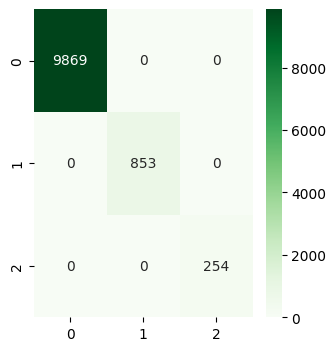

In [26]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

spark = SparkSession.builder \
    .appName("Model Evaluation") \
    .getOrCreate()

data = spark.read.csv('part-00000.csv', header=True, inferSchema=True)

feature_columns = ['HbA1c', 'GlucoseValue']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

# Converting string columns to float
data = data.withColumn("HbA1c", data["HbA1c"].cast("float")) \
            .withColumn("GlucoseValue", data["GlucoseValue"].cast("float"))

# Transforming dataFrame to features column
transformed_data = assembler.transform(data)

indexer = StringIndexer(inputCol='EventType', outputCol='label')

indexer_model = indexer.fit(transformed_data)

transformed_data_indexed = indexer_model.transform(transformed_data)

# Spliting data into training and testing
(train_data, test_data) = transformed_data_indexed.randomSplit([0.7, 0.3], seed=42)

#classification models
lr = LogisticRegression()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()

# Train
lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)
dt_model = dt.fit(train_data)

# predictions
lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)
dt_predictions = dt_model.transform(test_data)

# Evaluate the models
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

lr_accuracy = evaluator.evaluate(lr_predictions, {evaluator.metricName: "accuracy"})
rf_accuracy = evaluator.evaluate(rf_predictions, {evaluator.metricName: "accuracy"})
dt_accuracy = evaluator.evaluate(dt_predictions, {evaluator.metricName: "accuracy"})

lr_precision = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedPrecision"})
rf_precision = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedPrecision"})
dt_precision = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedPrecision"})

lr_recall = evaluator.evaluate(lr_predictions, {evaluator.metricName: "weightedRecall"})
rf_recall = evaluator.evaluate(rf_predictions, {evaluator.metricName: "weightedRecall"})
dt_recall = evaluator.evaluate(dt_predictions, {evaluator.metricName: "weightedRecall"})

lr_f1 = evaluator.evaluate(lr_predictions, {evaluator.metricName: "f1"})
rf_f1 = evaluator.evaluate(rf_predictions, {evaluator.metricName: "f1"})
dt_f1 = evaluator.evaluate(dt_predictions, {evaluator.metricName: "f1"})

print("Logistic Regression Metrics:")
print("Accuracy:", lr_accuracy)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)

print("\nRandom Forest Metrics:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

print("\nDecision Tree Metrics:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)

lr_pred_and_labels = lr_predictions.select('prediction', 'label').rdd.map(tuple)
rf_pred_and_labels = rf_predictions.select('prediction', 'label').rdd.map(tuple)
dt_pred_and_labels = dt_predictions.select('prediction', 'label').rdd.map(tuple)

lr_metrics = MulticlassMetrics(lr_pred_and_labels)
rf_metrics = MulticlassMetrics(rf_pred_and_labels)
dt_metrics = MulticlassMetrics(dt_pred_and_labels)

# Confusion matrix
lr_confusion_matrix = lr_metrics.confusionMatrix().toArray()
rf_confusion_matrix = rf_metrics.confusionMatrix().toArray()
dt_confusion_matrix = dt_metrics.confusionMatrix().toArray()

# Plot
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.heatmap(lr_confusion_matrix, annot=True, cmap='Greens', fmt='g')
